## Training a Perceptron
I was recently reading the book 'Why Machines Learn' by Anil Ananthaswamy. The motivation to create this notebook came when I was on the chapter 'The Great Kernel Rope Trick' that describes how Support Vector Machines Work. This notebook is however about perceptrons. In this notebook I will try and develop a perceptron trainer from scratch and watch as it tries to figure out one of the possible 'seperating' hyper planes between two clouds of points. The way Anil had written the organized his chapter on SVMs made my look back at my notes and wonder if I can see an actual perceptron in action. It is a very simple algorithm, but it doesn't make it any less fun to try and implement.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

### Creating Point Clouds
The first order of business will be to create point clouds which are normally distributed around two distinct points in a 2d plane. We can take $c1 = (-2,-2)$ and $c2 = (2,2)$. There will be $n=300$ points in each point cloud. I chose the number 300 randomly.

/var/folders/nb/_00pn8317zbfjmjqrbsj4qsw0000gn/T/ipykernel_5039/3186188752.py:12: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  cloud1 = np.random.multivariate_normal(c1, cov1, n)


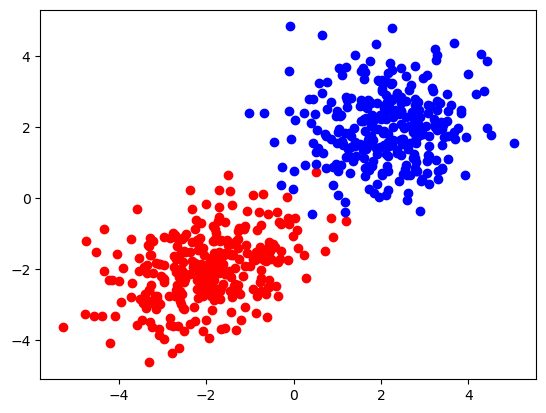

In [123]:
# Creating point clouds
c1 = [-2, -2]
# Covariance matrix of the first point cloud
cov1 = [[1, 0], [1, 1]]
# Creating the second point cloud
c2 = [2, 2]
# Covariance matrix of the second point cloud 
cov2 = [[1, 0], [0, 1]]
# Number of points in each point cloud
n = 300
# Generate the actual clouds
cloud1 = np.random.multivariate_normal(c1, cov1, n)
cloud2 = np.random.multivariate_normal(c2, cov2, n)
# We can now plot the clouds with different colors
plt.scatter(cloud1[:, 0], cloud1[:, 1], color='red')
plt.scatter(cloud2[:, 0], cloud2[:, 1], color='blue')

## Some Coordinate Geometry
When we define a seperating hyperplane it will be defined by a weight vector $\mathbf{w}$ and a bias $b$. The seperating hyperplane will be perpendicular to $\mathbf{w}$ and a distance of $b$ from the origin. We need a way to draw this plane given these parameters. We will define a function for the same.

We will have to use a bit of coordinate geometry here. We know that the unit vector in the direction of $\mathbf{w}$ is:

$$\hat{w} = \frac{w_1}{||\mathbf{w}||} \hat{i} + \frac{w_2}{||\mathbf{w}||} \hat{j}$$

We will compute this first. Then we will travel $-b$ units along this unit vector and find a point given by 

$$\left[\frac{w_1}{||\mathbf{w}||}(-b.cos\theta), \frac{w_2}{||\mathbf{w}||}(-b.sin\theta)\right]$$

Where \theta is given by 

$$\theta = tan^{-1}\left(\frac{w_2}{w_1}\right)$$

We will then draw a line perpendicular to the unit vector at this specific point. We know that a the unit vector perpendicular to the vector we have is:

$$\hat{w_p} = -\frac{w_2}{||\mathbf{w}||} \hat{i} + \frac{w_1}{||\mathbf{w}||} \hat{j}$$

We want a line which has the slope of this unit vector passing through the point defined above. This is given by:

$$y - y_0 = \left(\frac{-w_1}{w_2}\right) (x - x_0)$$

After a bit of algebra this becomes

$$ y = \left(\frac{-w_1}{w_2}\right)\left(x - \frac{w_1}{||\mathbf{w}||}(-b.cos\theta) \right) + \frac{w_2}{||\mathbf{w}||}(-b.sin\theta)$$

Round about mathematics but it works.


In [20]:
# Defining a function to plot the seperating hyperplane given the weights and bias
def plot_seperating_hyperplane(weights: np.array, bias: float):
    # Define the x points for the plot. 
    x = np.linspace(-6, 6, 100)
    # We use a bit of coordinate geometry here.
    # Compute the unit vector along the weights
    unit_vector = weights / np.linalg.norm(weights)
    # Compute the angle theta that the vector makes along the x axis
    theta = np.arctan(unit_vector[1] / unit_vector[0])
    # Compute the unit vector normal to the weights unit vector
    unit_normal = np.array([-unit_vector[1], unit_vector[0]])
    # Compute the y points to the x points using the equation of the line
    y = (-weights[1]/weights[0])*(x - unit_vector[0]*(-bias*np.cos(theta))) + unit_vector[0]*(-bias*np.sin(theta))
    # Return x and y
    return x, y

## Training the Perceptron
That is pretty much it and we can get down to the business of training the perceptron. The perceptron algorithm is very simple. 

1. Initialize a weight vector $\mathbf{w} = 0$
2. For each data point in the training data set do the following:

    a. If $y\mathbf{w}^T\mathbf{x} <= 0 $ then update the weights to $\mathbf{w_{new}} = \mathbf{w_{old}} + y\mathbf{x}$
3. If in step 2 we have no new updates then terminate.

We will create a small variation of this. We will call a full execution of step 2 an epoch and run the algorithm for a prespecified number of epochs and take snapshots to see where we are. This should be simple enough. Note that we will also make a small change to include the bias in the vector $\mathbf{w}$. This is a classic trick where in we define another feature whose value is always 1.

In [70]:
def single_training_epoch(weights: np.array, bias: float, cloud1, cloud2):
    # Note here that cloud1 is always considered to be -1 as a label
    # cloud 2 is always considered to be 1 as a label
    # We can flip this around if we so desire.
    enhanced_weights = np.array([bias, weights[0], weights[1]])
    for point in cloud1:
        enhanced_point = np.array([1, point[0], point[1]])
        # Compute the dot product of the weights and the point
        product = -1 * np.dot(enhanced_weights, enhanced_point)
        # If the dot product is positive, then the point is misclassified
        if product <= 0:
            # Update the weights and bias
            enhanced_weights = enhanced_weights - enhanced_point
    for point in cloud2:
        enhanced_point = np.array([1, point[0], point[1]])
        # Compute the dot product of the weights and the point
        product = 1 * np.dot(enhanced_weights, enhanced_point)
        # If the dot product is positive, then the point is misclassified
        if product <= 0:
            # Update the weights and bias
            enhanced_weights = enhanced_weights + enhanced_point
    return np.array([enhanced_weights[1], enhanced_weights[2]]), enhanced_weights[0]

In [124]:
# Now set the starting weights and bias
weights = np.array([1,0], dtype=np.float32)
bias = 0.1

In [128]:
# Run 1000 epochs of training
for epoch in range(1000):
    weights, bias = single_training_epoch(weights, bias, cloud1, cloud2)

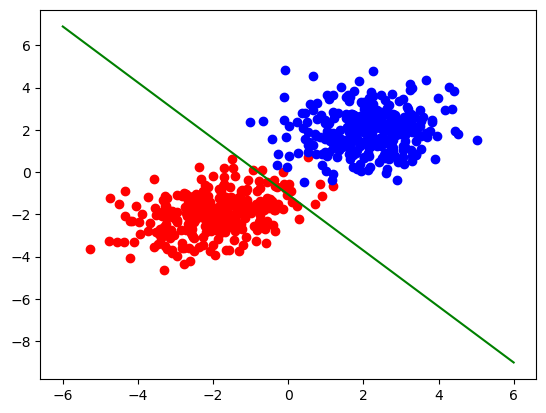

In [129]:
# Plot the results
plt.scatter(cloud1[:, 0], cloud1[:, 1], color='red')
plt.scatter(cloud2[:, 0], cloud2[:, 1], color='blue')
x, y = plot_seperating_hyperplane(weights, bias)
plt.plot(x, y, color='green')

And Voila! We have a semblance of a seperating hyperplane after just a few epochs of training!